# 6 - Basic CNN adversarial benchmark with Cleverhans

### Imports

In [1]:
%matplotlib inline

import numpy as np
import keras
from keras import backend, applications
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Activation, Convolution2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_eval, model_train
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import pair_visual
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Utils functions

In [2]:
CLASSES = [
    'Arc de Triomphe', 'Big Ben', 'Casa Loma', 'Castel Santangelo', 'Charlottenburg Palace', 
    'Colosseum', 'Dresden Frauenkirche', 'Eiffel Tower', 'Independence Hall',
    'Leaning Tower of Pisa', 'Milan Cathedral', 'Notre Dame Cathedral', 'Pantheon',
    'Reichstag', 'Sacre Coeur Basilica', 'Savior on Blood Church', 'St Basil Cathedral',
    'St Louis Cathedral', 'St Paul Cathedral', 'Statue of Liberty', 'Stephansdom',
    'Taj Mahal', 'Trevi Foutain', 'Tyn Church', 'Westminster Abbey'
]

def decode_predictions(predictions):
    return CLASSES[predictions.argmax()], round(predictions.max(), 4) * 100

### Default parameters

In [3]:
img_width, img_height = 224, 224
n_classes = 25
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
train_samples = 40805
validation_samples = 8856
rng = np.random.RandomState([2017, 8, 30])

In [4]:
keras.layers.core.K.set_learning_phase(0)

In [5]:
# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)

### Define our model

In [6]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_width, img_height, 3))
y = tf.placeholder(tf.float32, shape=(None, n_classes))

In [7]:
# Load our model
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.load_weights('../models/data_augmentation.h5')

In [8]:
# Define TF model graph
preds = model(x)
print("Defined TensorFlow model graph.")

Defined TensorFlow model graph.


### Load images

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=validation_samples)

X_test, Y_test = validation_generator.next()

Found 8856 images belonging to 25 classes.


### Accuracy on legitimate examples

In [10]:
# Evaluate the accuracy of the MNIST model on legitimate test examples
batch_size = 32
eval_params = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
print('Test accuracy on legitimate examples: %0.4f' % acc)

Test accuracy on legitimate examples: 0.6977


### Generating adversarial examples

In [11]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {
    'eps': 0.01,
    'clip_min': 0.0,
    'clip_max': 1.0
}
adv_x = fgsm.generate(x, **fgsm_params)
# Consider the attack to be constant
adv_x = tf.stop_gradient(adv_x)
preds_adv = model(adv_x)

# We store some examples
with sess.as_default():
    feed_dict = {x: X_test[:5], y: Y_test[:5]}
    adv_array = adv_x.eval(feed_dict=feed_dict)
    pred_adv_array = preds_adv.eval(feed_dict=feed_dict)
    original_array = x.eval(feed_dict=feed_dict)
    pred_original_array = preds.eval(feed_dict=feed_dict)

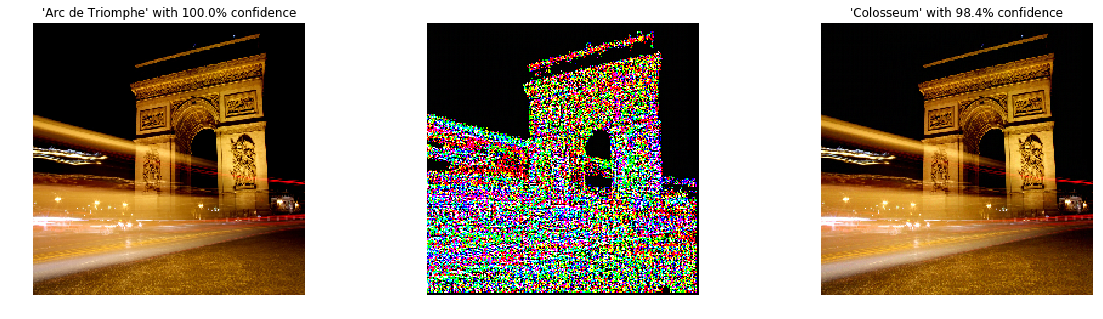

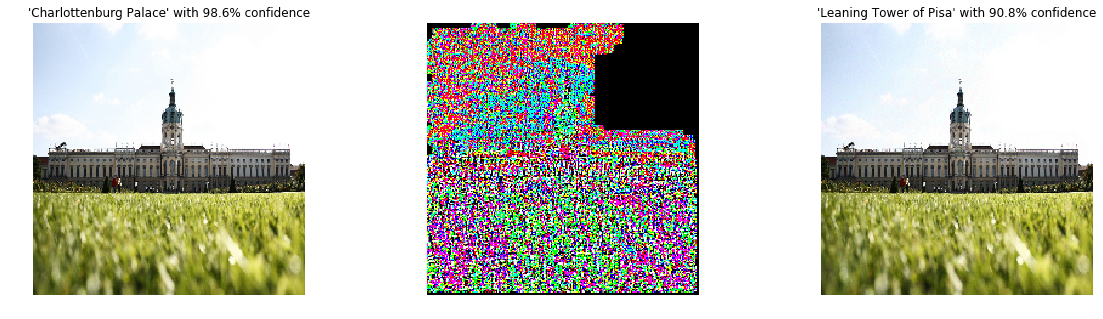

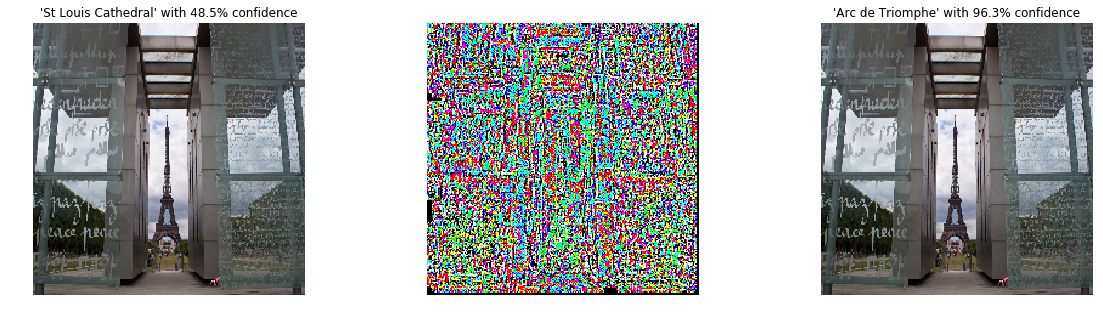

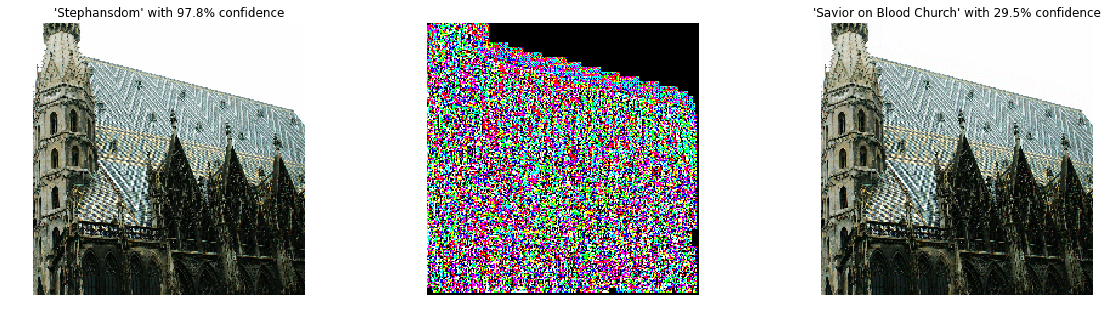

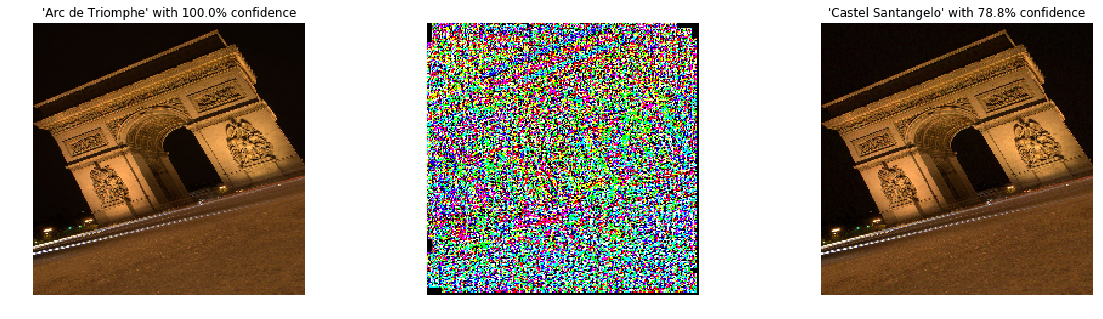

In [12]:
for i in range(5):
    figure = plt.figure(figsize=(20, 5))
    original = original_array[i]
    adversarial = adv_array[i]
    perturbation = adversarial - original
    
    original_prediction = decode_predictions(pred_original_array[i])
    adv_prediction = decode_predictions(pred_adv_array[i])
    
    for index, image in enumerate((original, perturbation, adversarial)):
        figure.add_subplot(1, 3, index + 1)
        plt.axis('off')
        plt.imshow(image)
        if index == 0:
            plt.title("'%s' with %.1f%% confidence" % original_prediction)
        elif index == 2:
            plt.title("'%s' with %.1f%% confidence" % adv_prediction)
    
    plt.show()
    figure.savefig('../images/%s_image.svg' % (fgsm_params['eps']), format='svg', dpi=1200)

### Accuracy on adversarial examples

In [13]:
# Evaluate the accuracy of the model on adversarial examples
batch_size = 32
eval_params = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds_adv, X_test, Y_test, args=eval_params)
print('Test accuracy on adversarial examples: %0.4f\n' % acc)

Test accuracy on adversarial examples: 0.2023



### Adversarial training (TODO!)

In [ ]:
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=train_samples)

X_train, Y_train = train_generator.next()

In [ ]:
# Redefine TF model graph
model_2 = model
preds_2 = model_2(x)
wrap_2 = KerasModelWrapper(model_2)
fgsm2 = FastGradientMethod(wrap_2, sess=sess)
preds_2_adv = model_2(fgsm2.generate(x, **fgsm_params))

def evaluate_2():
    # Accuracy of adversarially trained model on legitimate test inputs
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds_2, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy on legitimate examples: %0.4f' % accuracy)

    # Accuracy of the adversarially trained model on adversarial examples
    accuracy = model_eval(sess, x, y, preds_2_adv, X_test,
                          Y_test, args=eval_params)
    print('Test accuracy on adversarial examples: %0.4f' % accuracy)

    
train_params = {
    'nb_epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.001,
    'train_dir': '/tmp',
    'filename': 'basic_cnn.ckpt'
}

# Perform and evaluate adversarial training
model_train(sess, x, y, preds_2, X_train, Y_train,
            predictions_adv=preds_2_adv, evaluate=evaluate_2,
            args=train_params, save=False, rng=rng)